<a href="https://colab.research.google.com/github/Ekta-kature/FMMLprojectsandlab/blob/main/module_9_lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [11]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [12]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-12 15:16:53--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.10.76, 18.160.10.28, 18.160.10.22, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.10.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M   204MB/s    in 0.2s    

2024-05-12 15:16:54 (204 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]

replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [14]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


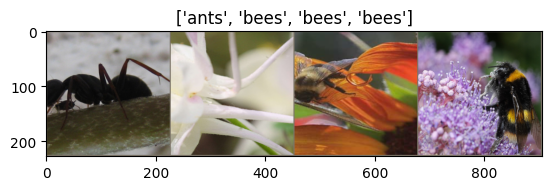

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [16]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [17]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [18]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [20]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5271 Acc: 0.7418

Epoch 1/4
----------
Loss: 0.6552 Acc: 0.7500

Epoch 2/4
----------
Loss: 0.5163 Acc: 0.8197

Epoch 3/4
----------
Loss: 0.5047 Acc: 0.8033

Epoch 4/4
----------
Loss: 0.4037 Acc: 0.8320



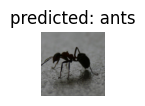

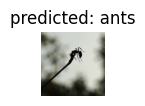

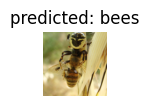

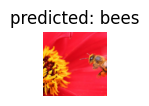

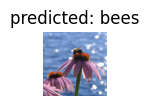

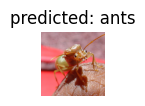

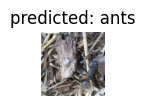

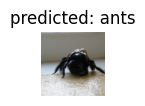

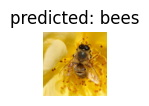

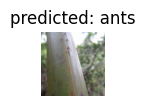

In [21]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
### **1) What is the significance of using data augmentations like resize, crop etc on training data?**
ans:-Data augmentation techniques like resize, crop, and horizontal flip serve several significant purposes in training data:

**Increased Variability:** By applying transformations like resizing and cropping, you introduce variability in the training data. This helps the model learn to generalize better to unseen data by exposing it to different viewpoints, scales, and orientations of the same object.

**Regularization:** Data augmentation acts as a form of regularization by introducing noise or perturbations into the training data. This helps prevent overfitting by discouraging the model from memorizing specific details of the training examples.

**Improved Robustness:**  Augmentations like horizontal flip help the model become more robust to variations in the input data. For example, if the training images predominantly contain objects oriented in one direction, horizontal flipping can help the model learn to recognize the same objects when they appear mirrored.

**Mitigating Overfitting:** Data augmentation can help mitigate overfitting, especially when the size of the training dataset is limited. By generating additional training samples through augmentation, the model is exposed to a wider range of variations, reducing the risk of overfitting to the limited training data.

**Better Generalization:** Ultimately, the goal of data augmentation is to improve the model's ability to generalize to new, unseen data. By simulating realistic variations that the model might encounter during inference, data augmentation helps ensure that the model can perform well in real-world scenarios beyond the training set.






### **2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)**

ans:-If you don't use a pretrained ResNet model and instead initialize the model with random weights, the performance might degrade significantly, especially considering the relatively small size of the dataset. Training a deep neural network from scratch on a small dataset can lead to overfitting and poor generalization.

By setting pretrained=False when initializing the ResNet model, you essentially start with randomly initialized weights for all layers, including the convolutional layers responsible for feature extraction. Without pretrained weights, the model has to learn meaningful representations of features directly from the small training dataset.

Here's what you can expect if you train the model without using pretrained weights:

Lower Accuracy: The model might achieve lower accuracy on both the training and validation sets compared to using transfer learning with pretrained weights. This is because the model has to learn features from scratch, which can be challenging with limited data.

Slower Convergence: Training from scratch often requires more epochs for the model to converge to a reasonable solution. Without the head start provided by pretrained weights, the optimization process may take longer.

Higher Risk of Overfitting: Training from scratch on a small dataset increases the risk of overfitting. The model may memorize the training examples rather than learning generalizable features, leading to poor performance on unseen data.

To assess the performance accurately, you would need to train the model without pretrained weights, evaluate it on the validation set, and compare the results with the performance of the pretrained model.







Epoch 0/4
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loss: 0.9007 Acc: 0.4508

Epoch 1/4
----------
Loss: 0.7664 Acc: 0.5902

Epoch 2/4
----------
Loss: 0.7337 Acc: 0.5943

Epoch 3/4
----------
Loss: 0.8339 Acc: 0.5779

Epoch 4/4
----------
Loss: 0.7292 Acc: 0.6311



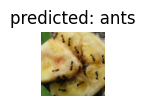

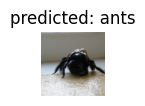

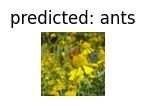

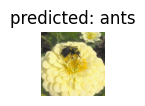

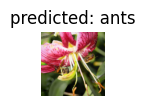

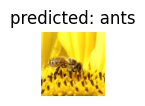

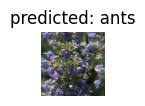

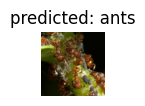

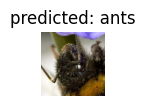

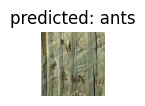

In [22]:
from torchvision import models

# Load ResNet model without pretrained weights
model_ft = models.resnet18(pretrained=False)  # Set pretrained=False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

visualize_model(model_ft)


### 3**) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model**?

ans:-Using a pretrained ResNet model on a dataset significantly different from the ants vs. bees dataset may or may not lead to good performance. The effectiveness of transfer learning depends on various factors, including the similarity between the source dataset (on which the model was pretrained) and the target dataset (ants vs. bees).

Here are some scenarios:

**Similar Domains:** If the source dataset used for pretraining is similar to the ants vs. bees dataset in terms of the visual characteristics of the images (e.g., similar objects, backgrounds, lighting conditions), then transfer learning with the pretrained model is likely to be beneficial. The pretrained model would have learned generic features that are useful for image classification tasks, and fine-tuning it on the ants vs. bees dataset would help it adapt to the specific characteristics of that dataset.

**Dissimilar Domains:** If the source dataset is significantly different from the ants vs. bees dataset (e.g., medical images, satellite images), transfer learning may still provide some benefits, but the performance might not be as good as when the domains are similar. The pretrained model may have learned high-level features that are transferable across domains, but fine-tuning on a dissimilar dataset may require more extensive adjustments or even retraining of some layers to adapt to the new domain.

**Domain Gap:** In cases where there is a large domain gap between the source and target datasets (e.g., natural images vs. medical images), transfer learning with a pretrained model might not be effective. In such scenarios, it might be better to train the model from scratch on the target dataset or explore domain adaptation techniques to bridge the gap between the domains.

In summary, while using a pretrained ResNet model can often provide a good starting point for transfer learning, the performance ultimately depends on the similarity between the source and target datasets. Evaluating the performance and making adjustments based on the specific characteristics of the datasets is crucial for achieving good results.





